In [1]:
try: 
    import librosa
except:
    !pip install librosa
try: 
    import optuna, plotly
except:
    !pip install optuna
    !pip install plotly
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn.functional as F

# Utils
import numpy as np
from numpy import ndarray
import logging, math
import matplotlib.pyplot as plt


# Base Scripts
from Libraries.Utils import *
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.VAE import MultiResolutionSTFTLoss

## Setup

### Initial Setup

In [2]:
remote_kernel: bool = True
device: str = "cuda" if torch.cuda.is_available() else "cpu"
training_data_name: str = "../Data/training_v2_full"
test_data_name: str = "../Data/unseen_test_data.npy"
model_name: str = "WaveDiffusion_v2"
full_model_path: str = OS().path_to_remote_path("../Models/{}.pth".format(model_name), remote_kernel)

### Logging

In [3]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Data Hyperparameters

In [4]:
n_samples: int = 128
batch_size: int = 12
n_workers: int = 1

### Data loading

In [5]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(training_data_name, remote_kernel))
md.create_validation_split(n_samples)
train_datatset, val_dataset = md.create_datasets()
train_dataloader, val_dataloader = md.create_dataloaders(batch_size, num_workers=n_workers)
logger.info(f"Created train dataset with length {len(md.train_dataset)} and validation dataset with length {len(md.val_dataset)}")

2025-08-28 11:57:40,984 - INFO - Created train dataset with length 128 and validation dataset with length 6


In [6]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(test_data_name, remote_kernel))
md.create_validation_split()
test_dataset, _ = md.create_datasets()
test_dataloader, _ = md.create_dataloaders(batch_size, num_workers=n_workers)
logger.info(f"Created test dataset with length {len(md.train_dataset)}")

2025-08-28 11:57:41,748 - INFO - Created test dataset with length 268


## Model Setup

### Hyperparameters

In [7]:
b1, b2 = (0.9, 0.99)
lr: float = 1e-4
n_epochs: int = 200
checkpoint_freq: int = 15
lr_restart_period: int = 30
restart_training: bool = True

train_v_obj: bool = True

### Models

In [8]:
u_net = UNet(in_channels=1, n_layers=4, base_channels=32, embed_dim=128, timesteps=1000, v_obj_sampler=True, kernel_size=9).to(device)

### Optimizers & Schedulers

In [9]:
optimizer = optim.AdamW(u_net.parameters(), lr, (b1, b2))
scheduler = optim.lr_scheduler.ConstantLR(optimizer, 1) #optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=lr_restart_period, eta_min=1e-7, T_mult=2)

### Load Model

In [10]:
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["u_net"])

    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-08-28 11:57:43,016 - INFO - Model WaveDiffusion_v2 loaded with ~17.57M Parameters


## Training

In [11]:
torch.backends.cudnn.benchmark = True

diffusion = Diffusion(noise_steps=1000, schedule="linear", v_obj=train_v_obj, device=device)
loss_fn = nn.MSELoss()

In [14]:
logger.info(f"Training started on {device}")
loss_list: list = []
total_time: float = 0.0

for e in range(n_epochs):
    total_loss: float = 0
    start_time: float = time.time()

    for b_idx, (audio, _) in enumerate(train_dataloader):
        audio: Tensor = audio.to(device)
        if audio.ndim == 2:
            audio = audio.unsqueeze(1)
        audio = audio[:, :, :262144//2]
        if not train_v_obj:
            x_t, noise, t = diffusion.prep_train_ddxm(audio)
            noise_recon = u_net(x_t, t)
            loss = loss_fn(noise, noise_recon)
        else:
            true_vel, x_sigma_t, sigma_t  = diffusion.prep_train_v_obj(audio)
            pred_vel = u_net(x_sigma_t, sigma_t)
            loss = loss_fn(pred_vel, true_vel)
        if loss.isnan():
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss
    else:
        u_net.eval()
        total_val_loss: float = 0
        for audio,_ in val_dataloader:
            audio: Tensor = audio.to(device)
            if audio.ndim == 2:
                audio = audio.unsqueeze(1)
            audio = audio[:, :, :262144//2]
            with torch.no_grad():
                if not train_v_obj:
                    x_t, noise, t = diffusion.prep_train_ddxm(audio)
                    noise_recon = u_net(x_t, t)
                    total_val_loss += loss_fn(noise, noise_recon)
                else:
                    true_vel, x_sigma_t, sigma_t  = diffusion.prep_train_v_obj(audio)
                    pred_vel = u_net(x_sigma_t, sigma_t)
                    total_val_loss += loss_fn(pred_vel, true_vel)
        #plt.plot((x_t - noise_recon)[1][0].cpu().numpy())
        #plt.show()  
        u_net.train()

        epoch_time = time.time() - start_time
        total_time += epoch_time
        remaining_time = int((total_time / (e + 1)) * (n_epochs - e - 1))
        avg_loss = total_loss / len(train_dataloader)
        avg_val_loss = total_val_loss / len(val_dataloader)
        loss_list.append({"avg_loss": avg_loss, "avg_val_loss": avg_val_loss})
        scheduler.step()

        logger.info(f"Epoch {e + 1:03d}: Avg. Loss: {avg_loss:.3e} Avg. Val Loss: {avg_val_loss:.3e} Remaining Time: {remaining_time // 3600:02d}h {(remaining_time % 3600) // 60:02d}min {round(remaining_time % 60):02d}s LR: {optimizer.param_groups[0]['lr']:.4e}")

        if checkpoint_freq > 0 and (e + 1) % checkpoint_freq == 0:
                checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1:03d}.pth"
                torch.save({"u_net": u_net.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, checkpoint_path)
                if e + 1 != checkpoint_freq:
                    last_path: str = f"{full_model_path[:-4]}_epoch_{(e + 1) - checkpoint_freq:03d}.pth"
                    OS().del_if_exists(last_path)
                logger.light_debug(f"Checkpoint saved model to {checkpoint_path}")
        continue
    break
else:
    torch.save({"u_net": u_net.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, full_model_path)
    logger.light_debug(f"Saved model to {full_model_path}")

    if checkpoint_freq > 0:
        checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1 - ((e + 1) % checkpoint_freq):03d}.pth"
        OS().del_if_exists(checkpoint_path)

2025-08-27 18:10:58,741 - INFO - Training started on cuda
2025-08-27 18:11:17,891 - INFO - Epoch 001: Avg. Loss: 4.178e-01 Avg. Val Loss: 4.948e-01 Remaining Time: 01h 03min 30s LR: 1.0000e-04
2025-08-27 18:11:24,328 - INFO - Epoch 002: Avg. Loss: 2.878e-01 Avg. Val Loss: 4.219e-01 Remaining Time: 00h 42min 09s LR: 1.0000e-04
2025-08-27 18:11:30,805 - INFO - Epoch 003: Avg. Loss: 2.045e-01 Avg. Val Loss: 3.572e-01 Remaining Time: 00h 35min 00s LR: 1.0000e-04
2025-08-27 18:11:37,290 - INFO - Epoch 004: Avg. Loss: 1.359e-01 Avg. Val Loss: 3.412e-01 Remaining Time: 00h 31min 22s LR: 1.0000e-04
2025-08-27 18:11:43,760 - INFO - Epoch 005: Avg. Loss: 1.482e-01 Avg. Val Loss: 1.544e-01 Remaining Time: 00h 29min 09s LR: 1.0000e-04
2025-08-27 18:11:50,260 - INFO - Epoch 006: Avg. Loss: 1.351e-01 Avg. Val Loss: 7.038e-02 Remaining Time: 00h 27min 39s LR: 1.0000e-04
2025-08-27 18:11:56,769 - INFO - Epoch 007: Avg. Loss: 1.319e-01 Avg. Val Loss: 8.508e-02 Remaining Time: 00h 26min 33s LR: 1.0000e-

KeyboardInterrupt: 

In [12]:
def mse(a: Tensor, b: Tensor) -> float:
    return F.mse_loss(a, b).item()

def snr_db(ref: Tensor, est: Tensor) -> float:
    num = torch.sum(ref.float() ** 2).item()
    err = torch.sum((ref.float() - est.float()) ** 2).item() + 1e-12
    return 10.0 * np.log10(num / err) if err > 0 else float("inf")

def save_wav_np(arr: ndarray, fname: str, sample_rate: int = 22050):
    try:
        AudioData(arr.astype(np.float32)).save_audio_file(fname)
        print(f"Saved {fname} ({len(arr)/sample_rate:.2f}s)")
    except Exception as e:
        print(f"Failed to save {fname}: {e}")

def run_v_obj_diagnostics_class(diffusion: Diffusion, u_net: torch.nn.Module,
                                val_dataloader, num_samples: int = 4,
                                len_sample: int = 2**18,
                                sigma_list: list[float] = [0.05, 0.25, 0.5],
                                sample_rate: int = 32000,
                                downsample_plot: int = 16):

    u_net.eval()
    diagnostics: list = {}

    audio_batch, _ = next(iter(val_dataloader))
    audio_batch = audio_batch.to(diffusion.device)
    if audio_batch.ndim == 2:
        audio_batch = audio_batch.unsqueeze(1)
    audio_batch = audio_batch[:num_samples,:, :len_sample].detach().clone()  # [B,C,L]
    
    B, C, L = audio_batch.shape
    print(f"Diagnostics on batch shape {audio_batch.shape}")

    for sigma_val in sigma_list:
        print(f"\n=== Sigma = {sigma_val} ===")
        sigma_b = torch.full((B,), float(sigma_val), device=diffusion.device, dtype=torch.float32)

        # Generate x_sigma and eps
        x_sigma, eps_true = diffusion.noise_img_v_obj(audio_batch, sigma_b)

        # True velocity
        # True velocity
        a, b = diffusion.get_semicircle_weights(sigma_b)
        true_v = a * eps_true - b * audio_batch   # FIX

        # Recover eps from true velocity
        eps_from_true_v = (true_v + b * audio_batch) / a
        mse_eps_rec = mse(eps_from_true_v, eps_true)
        snr_eps_rec = snr_db(eps_true, eps_from_true_v)

        # Reconstruct x0 from true velocity
        x0_from_true_v = (a * eps_from_true_v - true_v) / b
        mse_x0_true = mse(x0_from_true_v, audio_batch)
        snr_x0_true = snr_db(audio_batch, x0_from_true_v)

        print(f"eps recovery from true_v -> MSE={mse_eps_rec:.4e}, SNR={snr_eps_rec:.2f} dB")
        print(f"x0 recovery from true_v -> MSE={mse_x0_true:.4e}, SNR={snr_x0_true:.2f} dB")

        # Model prediction
        with torch.no_grad():
            pred_v = u_net(x_sigma, sigma_b)

        mse_v = mse(pred_v, true_v)
        snr_v = snr_db(true_v, pred_v)

        # Recover eps and x0 from predicted velocity
        eps_from_pred_v = (pred_v + b * audio_batch) / a
        x0_from_pred_v = (a * eps_from_pred_v - pred_v) / b

        mse_eps_pred = mse(eps_from_pred_v, eps_true)
        snr_eps_pred = snr_db(eps_true, eps_from_pred_v)
        mse_x0_pred = mse(x0_from_pred_v, audio_batch)
        snr_x0_pred = snr_db(audio_batch, x0_from_pred_v)

        print(f"pred_v vs true_v -> MSE={mse_v:.4e}, SNR={snr_v:.2f} dB")
        print(f"eps from pred_v -> MSE={mse_eps_pred:.4e}, SNR={snr_eps_pred:.2f} dB")
        print(f"x0 from pred_v -> MSE={mse_x0_pred:.4e}, SNR={snr_x0_pred:.2f} dB")

        # Optional: one-step DDIM-style consistency
        sigma_next = max(0.0, sigma_val - 0.01)
        sigma_next_b = torch.full((B,), sigma_next, device=diffusion.device)
        a1, b1 = diffusion.get_semicircle_weights(sigma_next_b)
        e_t_true = eps_from_true_v
        e_t_pred = eps_from_pred_v
        x_next_true = a1 * audio_batch + b1 * e_t_true
        x_next_pred = a1 * x0_from_pred_v + b1 * e_t_pred
        mse_step = mse(x_next_true, x_next_pred)
        print(f"One-step next-state consistency: MSE={mse_step:.4e}")

        diagnostics[sigma_val] = {
            "mse_eps_rec_true": mse_eps_rec,
            "snr_eps_rec_true": snr_eps_rec,
            "mse_x0_true": mse_x0_true,
            "snr_x0_true": snr_x0_true,
            "mse_v": mse_v,
            "snr_v": snr_v,
            "mse_eps_pred": mse_eps_pred,
            "snr_eps_pred": snr_eps_pred,
            "mse_x0_pred": mse_x0_pred,
            "snr_x0_pred": snr_x0_pred,
            "mse_xnext": mse_step
        }

        # Plotting velocities and reconstructions for first few samples
        for i in range(min(B, num_samples)):
            tv = true_v[i, 0].cpu().numpy()[::downsample_plot]
            pv = pred_v[i, 0].cpu().numpy()[::downsample_plot]
            xs = x_sigma[i, 0].cpu().numpy()[::downsample_plot]
            x0t = audio_batch[i, 0].cpu().numpy()[::downsample_plot]
            x0_true_rec = x0_from_true_v[i, 0].cpu().numpy()[::downsample_plot]
            x0_pred_rec = x0_from_pred_v[i, 0].cpu().numpy()[::downsample_plot]

            plt.figure(figsize=(12,3))
            plt.plot(tv, label="true_v")
            plt.plot(pv, label="pred_v", alpha=0.8)
            plt.title(f"velocities sigma={sigma_val:.3f} sample={i}")
            plt.legend(); plt.tight_layout(); plt.show()

            plt.figure(figsize=(12,3))
            plt.plot(xs, label="x_sigma (noisy)")
            plt.plot(x0t, label="x0 true")
            plt.plot(x0_true_rec, label="x0 from true_v", linestyle="--")
            plt.plot(x0_pred_rec, label="x0 from pred_v", linestyle=":")
            plt.title(f"x0 reconstructions sigma={sigma_val:.3f} sample={i}")
            plt.legend(); plt.tight_layout(); plt.show()

            # Save WAVs
            save_wav_np(audio_batch[i,0].cpu().numpy(), f"x0_true_sigma{sigma_val:.3f}_i{i}.wav", sample_rate)
            save_wav_np(x_sigma[i,0].cpu().numpy(), f"x_sigma_sigma{sigma_val:.3f}_i{i}.wav", sample_rate)
            save_wav_np(x0_from_pred_v[i,0].cpu().numpy(), f"x0_pred_sigma{sigma_val:.3f}_i{i}.wav", sample_rate)

    print("\nDiagnostics complete.")
    return diagnostics


Diagnostics on batch shape torch.Size([4, 1, 131072])

=== Sigma = 0.05 ===
eps recovery from true_v -> MSE=7.5743e-17, SNR=161.11 dB
x0 recovery from true_v -> MSE=1.0369e-13, SNR=116.76 dB
pred_v vs true_v -> MSE=4.5235e-01, SNR=3.43 dB
eps from pred_v -> MSE=4.5515e-01, SNR=3.43 dB
x0 from pred_v -> MSE=1.0650e-13, SNR=116.65 dB
One-step next-state consistency: MSE=1.7945e-03


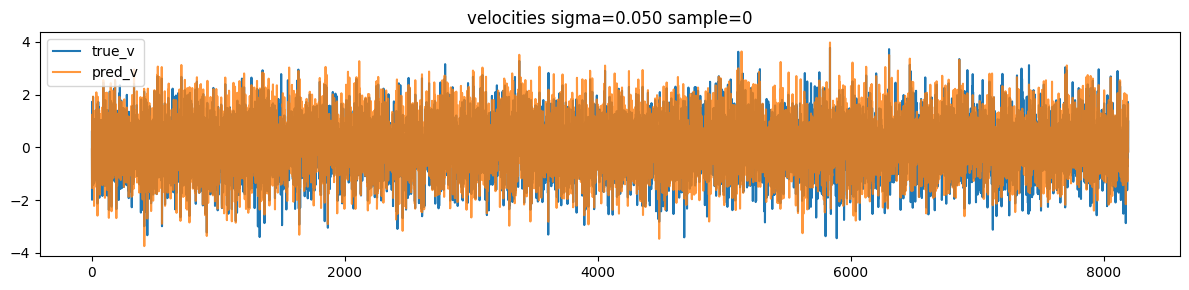

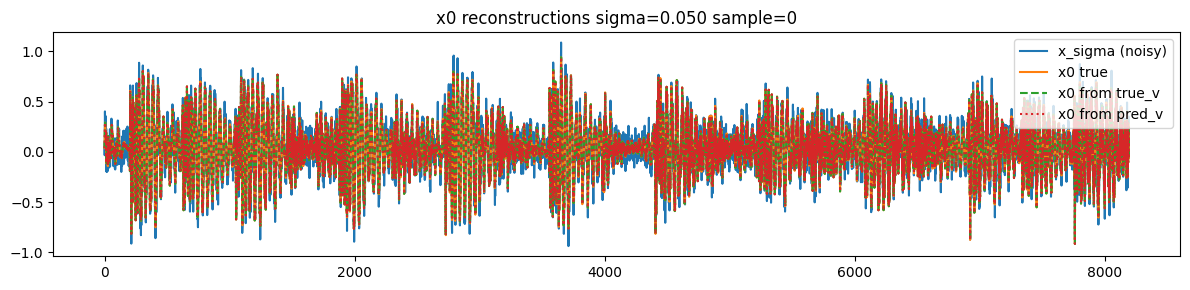

Saved x0_true_sigma0.050_i0.wav (4.10s)
Saved x_sigma_sigma0.050_i0.wav (4.10s)
Saved x0_pred_sigma0.050_i0.wav (4.10s)


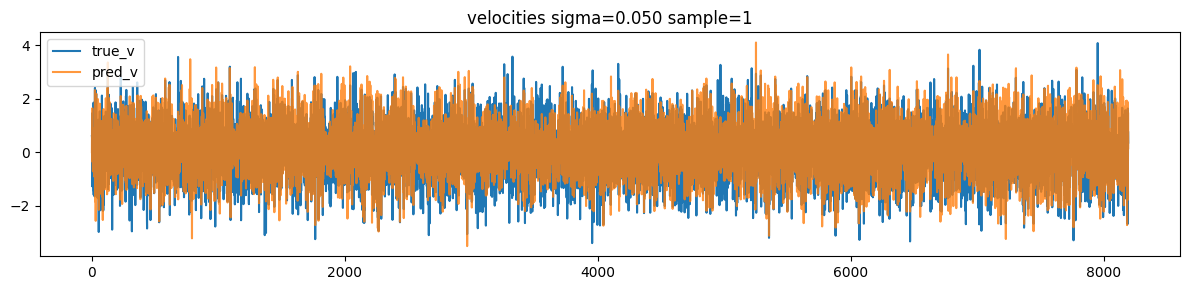

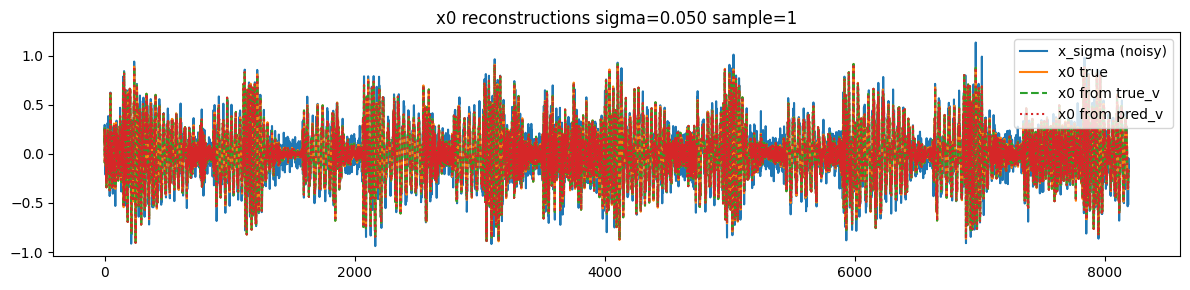

Saved x0_true_sigma0.050_i1.wav (4.10s)
Saved x_sigma_sigma0.050_i1.wav (4.10s)
Saved x0_pred_sigma0.050_i1.wav (4.10s)


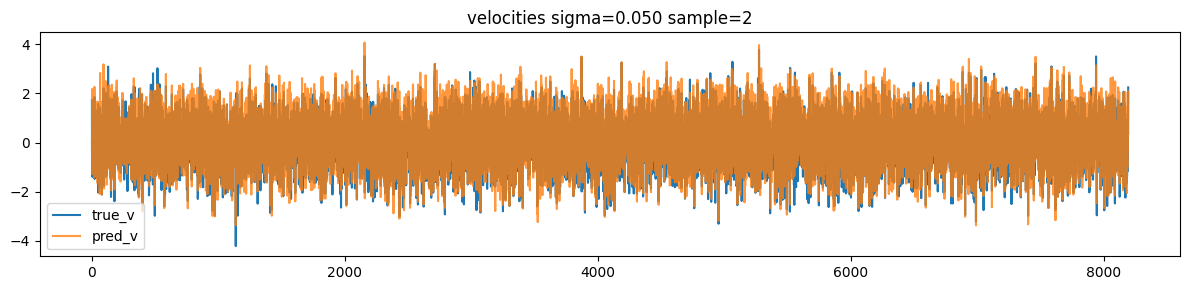

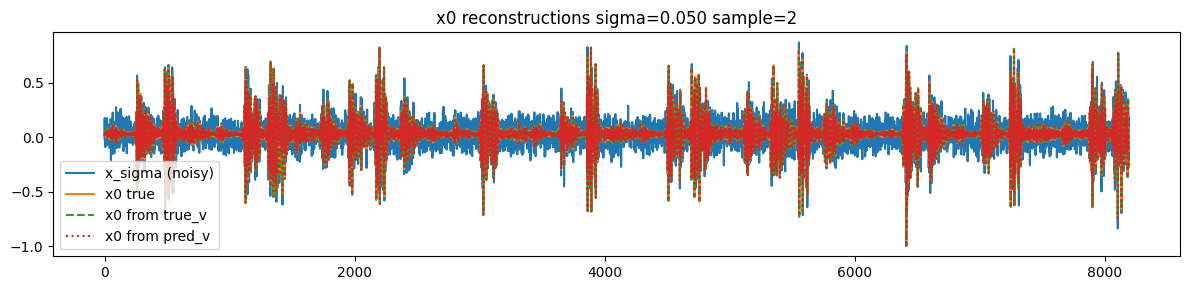

Saved x0_true_sigma0.050_i2.wav (4.10s)
Saved x_sigma_sigma0.050_i2.wav (4.10s)
Saved x0_pred_sigma0.050_i2.wav (4.10s)


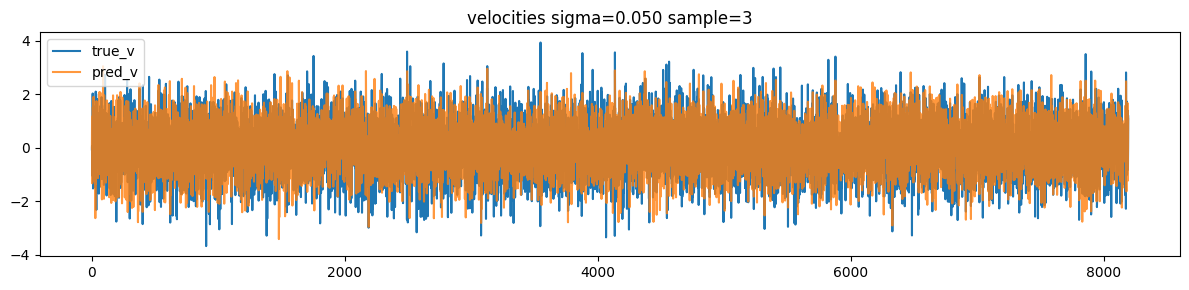

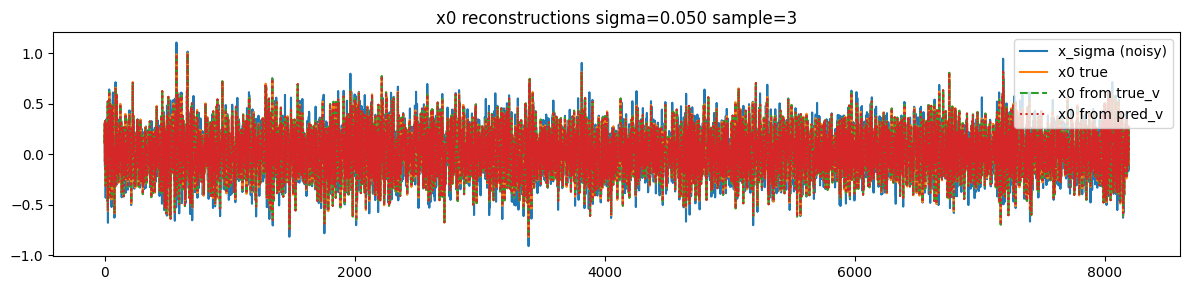

Saved x0_true_sigma0.050_i3.wav (4.10s)
Saved x_sigma_sigma0.050_i3.wav (4.10s)
Saved x0_pred_sigma0.050_i3.wav (4.10s)

=== Sigma = 0.25 ===
eps recovery from true_v -> MSE=7.7119e-16, SNR=151.12 dB
x0 recovery from true_v -> MSE=3.9552e-15, SNR=130.94 dB
pred_v vs true_v -> MSE=9.4714e-02, SNR=9.59 dB
eps from pred_v -> MSE=1.1096e-01, SNR=9.56 dB
x0 from pred_v -> MSE=4.4662e-15, SNR=130.42 dB
One-step next-state consistency: MSE=1.5037e-02


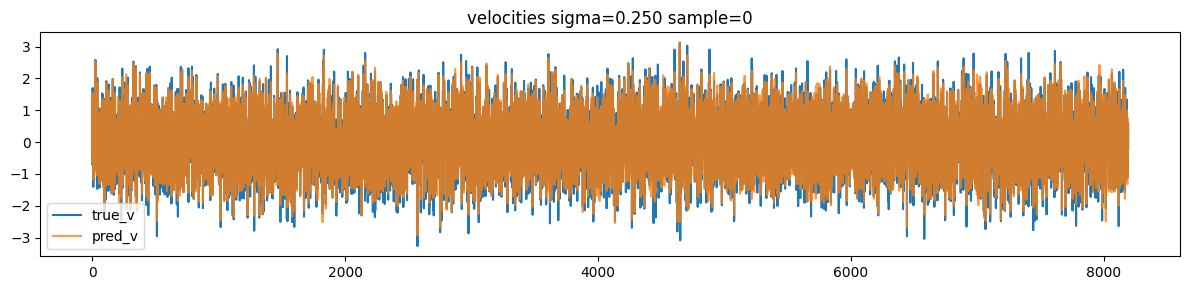

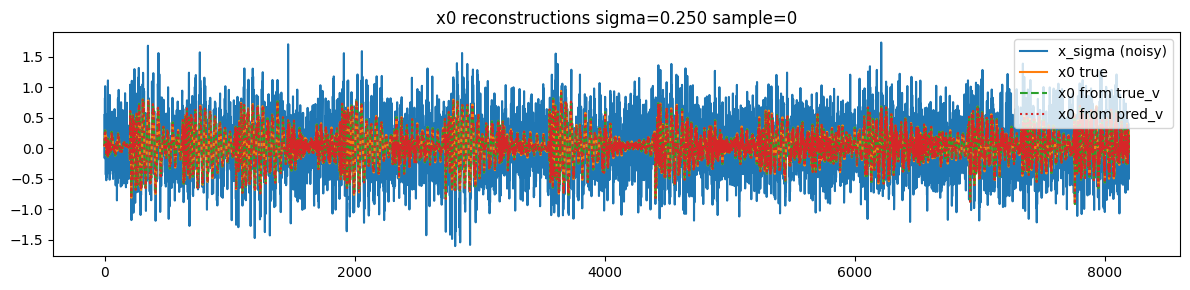

Saved x0_true_sigma0.250_i0.wav (4.10s)
Saved x_sigma_sigma0.250_i0.wav (4.10s)
Saved x0_pred_sigma0.250_i0.wav (4.10s)


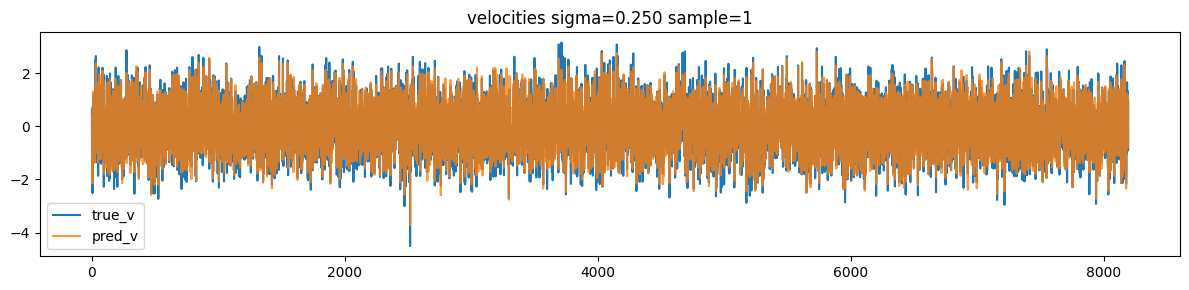

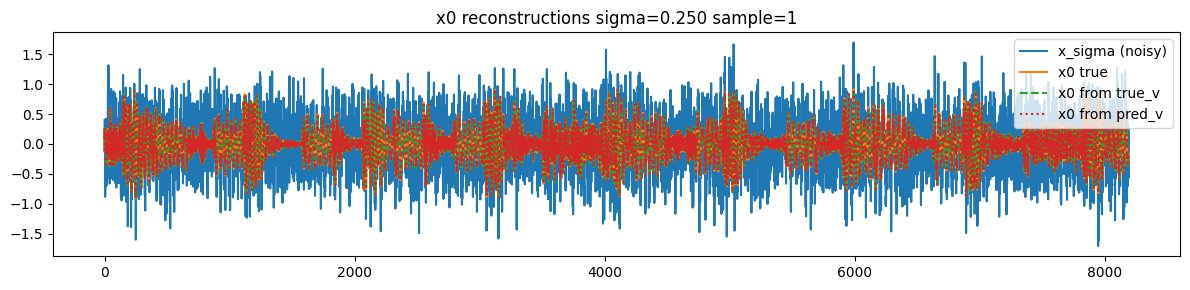

Saved x0_true_sigma0.250_i1.wav (4.10s)
Saved x_sigma_sigma0.250_i1.wav (4.10s)
Saved x0_pred_sigma0.250_i1.wav (4.10s)


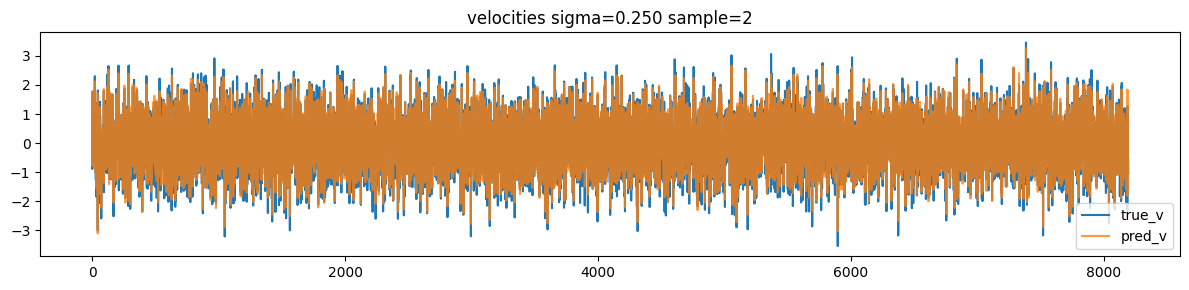

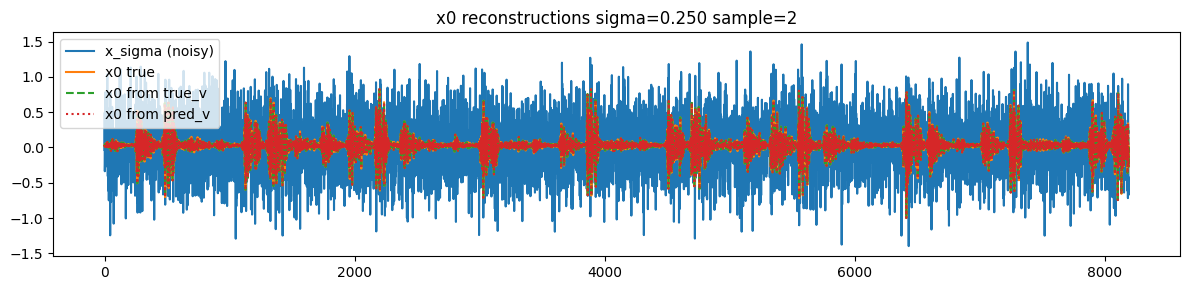

Saved x0_true_sigma0.250_i2.wav (4.10s)
Saved x_sigma_sigma0.250_i2.wav (4.10s)
Saved x0_pred_sigma0.250_i2.wav (4.10s)


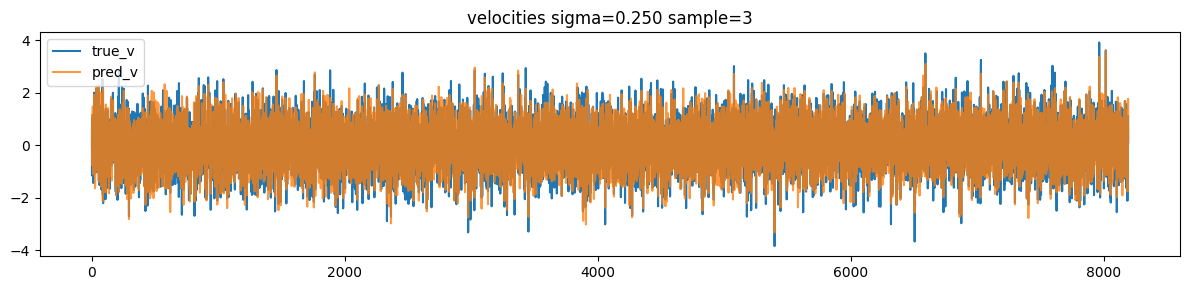

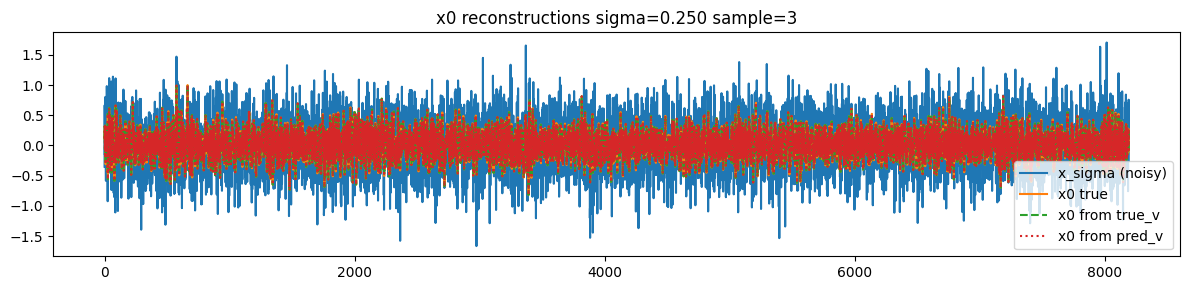

Saved x0_true_sigma0.250_i3.wav (4.10s)
Saved x_sigma_sigma0.250_i3.wav (4.10s)
Saved x0_pred_sigma0.250_i3.wav (4.10s)

=== Sigma = 0.5 ===
eps recovery from true_v -> MSE=1.3649e-15, SNR=148.64 dB
x0 recovery from true_v -> MSE=7.5904e-16, SNR=138.11 dB
pred_v vs true_v -> MSE=4.9292e-02, SNR=10.28 dB
eps from pred_v -> MSE=9.8584e-02, SNR=10.06 dB
x0 from pred_v -> MSE=1.1779e-15, SNR=136.20 dB
One-step next-state consistency: MSE=4.7744e-02


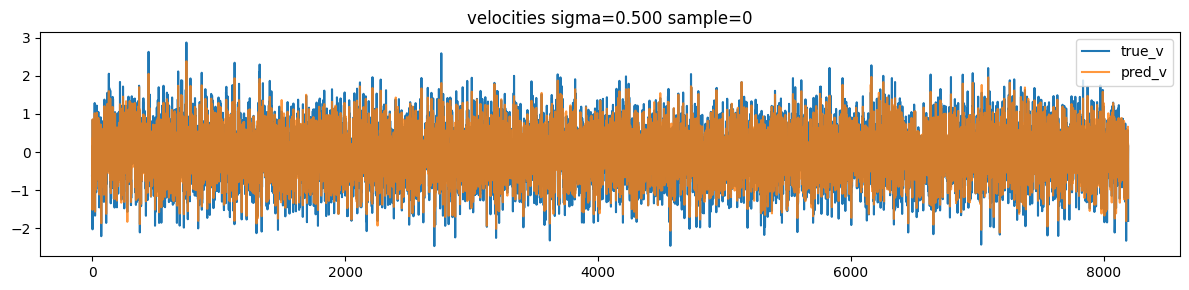

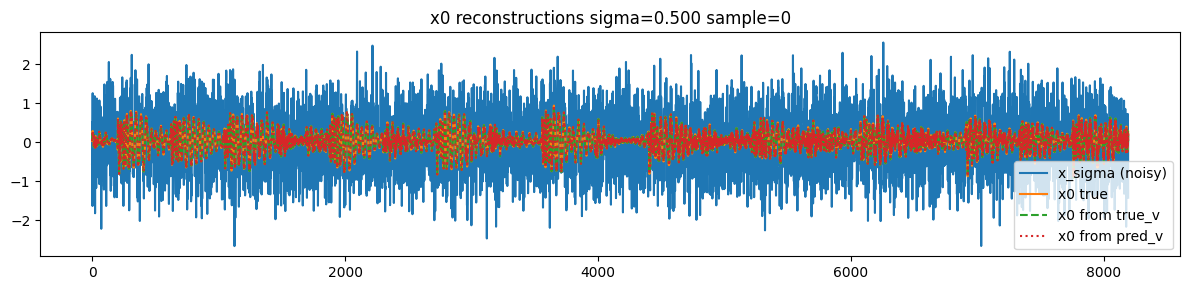

Saved x0_true_sigma0.500_i0.wav (4.10s)
Saved x_sigma_sigma0.500_i0.wav (4.10s)
Saved x0_pred_sigma0.500_i0.wav (4.10s)


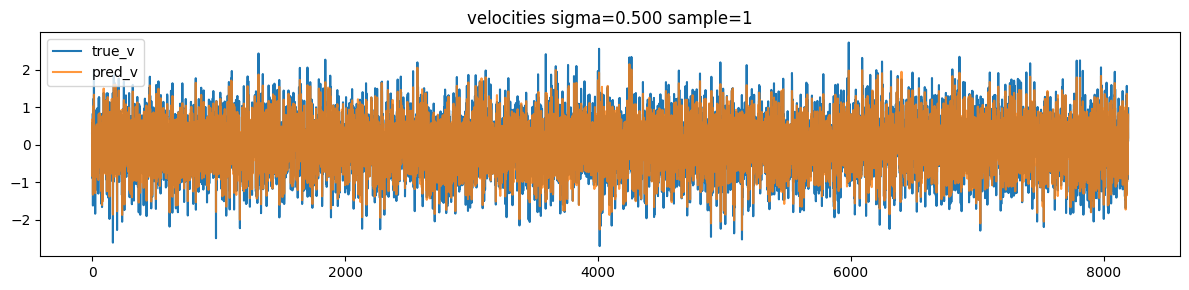

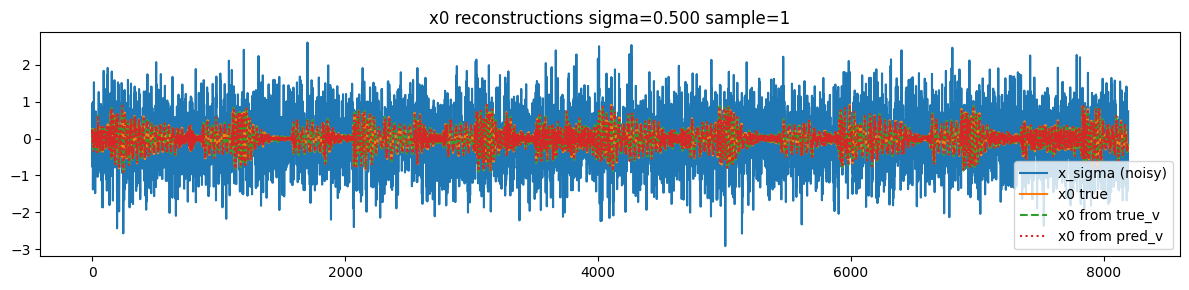

Saved x0_true_sigma0.500_i1.wav (4.10s)
Saved x_sigma_sigma0.500_i1.wav (4.10s)
Saved x0_pred_sigma0.500_i1.wav (4.10s)


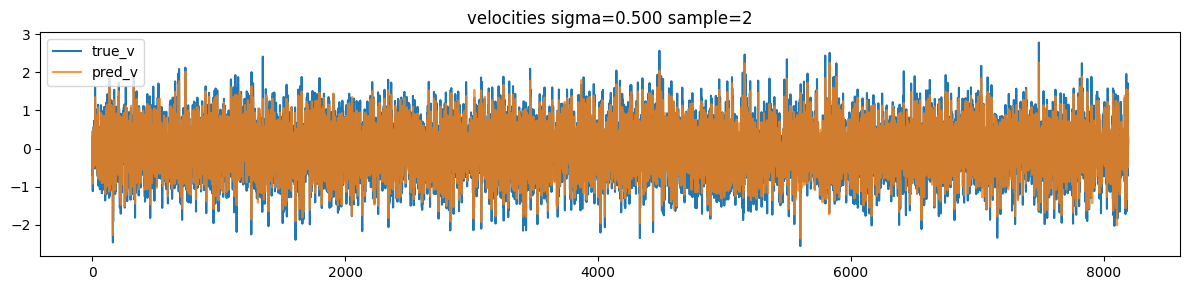

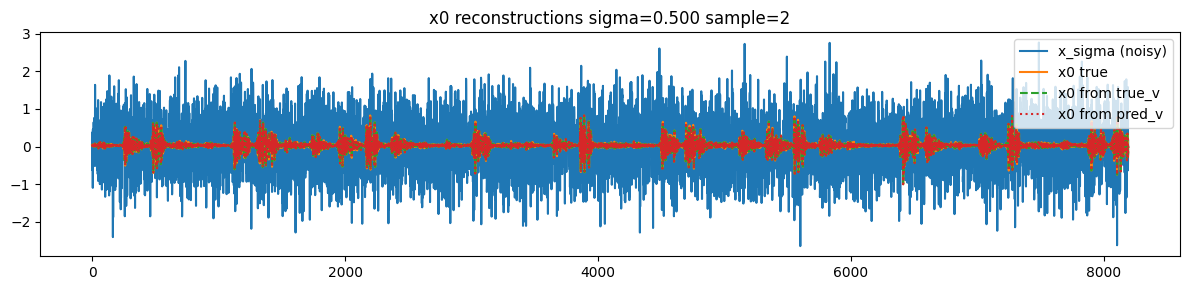

Saved x0_true_sigma0.500_i2.wav (4.10s)
Saved x_sigma_sigma0.500_i2.wav (4.10s)
Saved x0_pred_sigma0.500_i2.wav (4.10s)


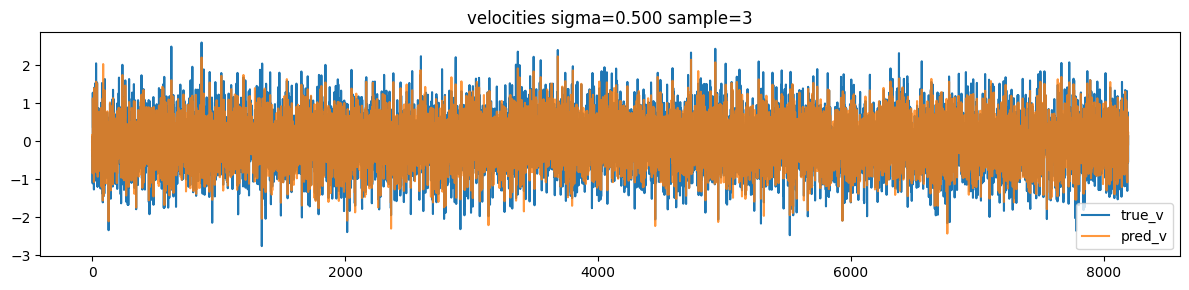

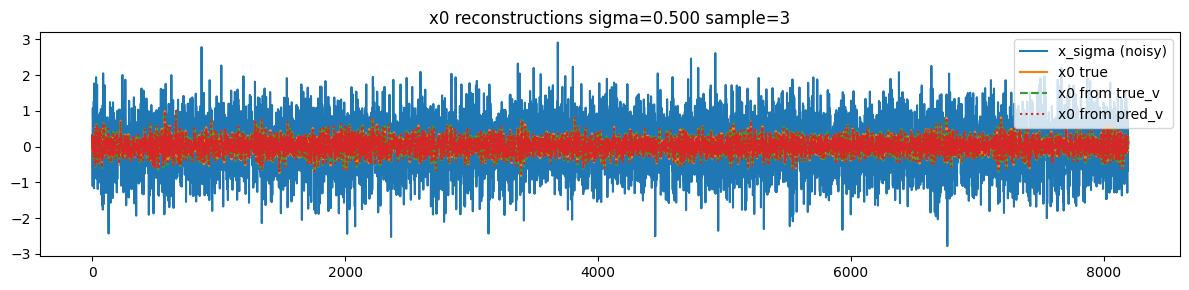

Saved x0_true_sigma0.500_i3.wav (4.10s)
Saved x_sigma_sigma0.500_i3.wav (4.10s)
Saved x0_pred_sigma0.500_i3.wav (4.10s)

Diagnostics complete.


{0.05: {'mse_eps_rec_true': 7.574317506858213e-17,
  'snr_eps_rec_true': 161.1084586189884,
  'mse_x0_true': 1.0368656345842442e-13,
  'snr_x0_true': 116.76142370595528,
  'mse_v': 0.4523472785949707,
  'snr_v': 3.429754533745042,
  'mse_eps_pred': 0.4551490843296051,
  'snr_eps_pred': 3.428365776491182,
  'mse_x0_pred': 1.064952569488839e-13,
  'snr_x0_pred': 116.64534796205169,
  'mse_xnext': 0.0017944934079423547},
 0.25: {'mse_eps_rec_true': 7.711932170471761e-16,
  'snr_eps_rec_true': 151.124937939309,
  'mse_x0_true': 3.955162748963542e-15,
  'snr_x0_true': 130.94499096512214,
  'mse_v': 0.09471418708562851,
  'snr_v': 9.592731477603929,
  'mse_eps_pred': 0.11096455901861191,
  'snr_eps_pred': 9.555454934001808,
  'mse_x0_pred': 4.466203137030479e-15,
  'snr_x0_pred': 130.41748936526574,
  'mse_xnext': 0.015037438832223415},
 0.5: {'mse_eps_rec_true': 1.3648814685139122e-15,
  'snr_eps_rec_true': 148.64093776895052,
  'mse_x0_true': 7.59043270572642e-16,
  'snr_x0_true': 138.1051

In [13]:
run_v_obj_diagnostics_class(diffusion, u_net, val_dataloader, len_sample=2**17)

2025-08-28 12:01:20,437 - INFO - Started sampling 10 samples on cuda
2025-08-28 12:01:36,083 - INFO - Created 10 samples


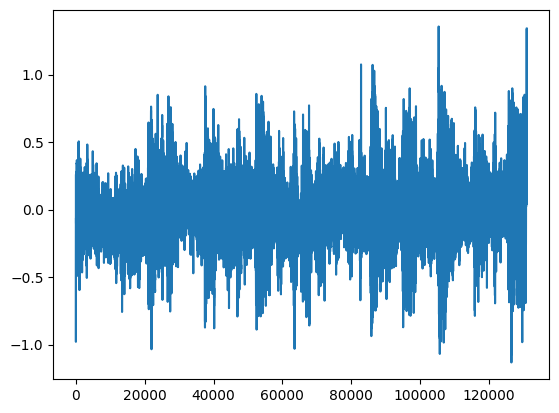

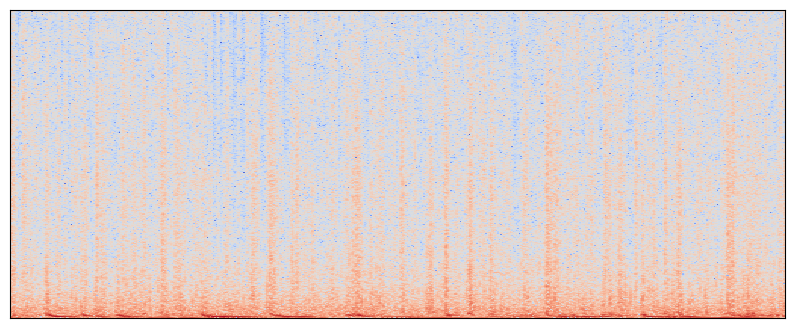

In [ ]:
if not train_v_obj:
    out = diffusion.bwd_diffusion_ddim(u_net, [10, 1, 262144], n_steps=100, eta=0)
else:
    out = diffusion.bwd_diffusion_v_obj(u_net, [10, 1, 262144//2], n_steps=100)

plt.plot(out[3][0])
plt.show() 
ad = AudioData(out[1][0])
ad.save_audio_file(f"Results/{model_name}_test_sample_s100.wav")
visualize_spectrogram(ad.audio_to_spectrogram())


In [ ]:
print(ad.spec_data)

(512, 512)


In [ ]:
out = diffusion.bwd_diffusion_ddpm(u_net, [10, 1, 262144])


2025-08-27 01:41:01,044 - INFO - Started sampling 10 samples on cuda
2025-08-27 01:46:18,443 - INFO - Created 10 samples


[[[ 0.39534333  0.5418447   0.2653833  ...  1.0510105   0.13064152
    1.0386037 ]]

 [[-0.4111534   0.2110385   0.5369208  ... -0.2894308   0.42187932
    1.8045486 ]]

 [[ 0.02207575 -0.60880274 -0.06673515 ... -0.84878385 -0.73774475
    0.4981793 ]]

 ...

 [[-1.0695639  -0.9618875   0.04462853 ...  0.52493834 -0.8661337
   -0.4087103 ]]

 [[-0.5084424  -1.12353    -0.08909657 ... -0.20829456  0.26885813
   -0.01137637]]

 [[-0.14322688 -0.17429894  0.13714527 ...  0.40215224  0.77247757
   -0.99636924]]]


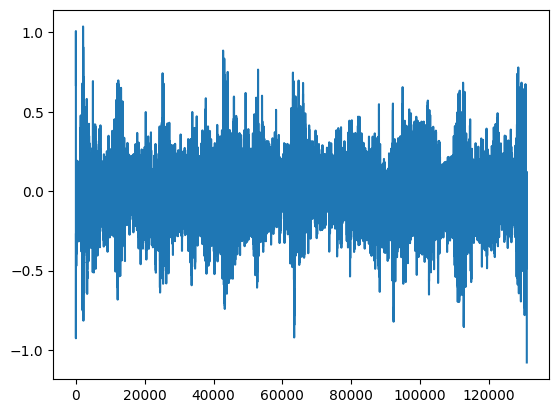

In [15]:
print(out)
out = torch.clamp(Tensor(out), min=-10, max=10).cpu().numpy()
plt.plot(out[4][0])
plt.show()  